In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
# Charger les données
file_path = "data/pdh_data.csv"
data = pd.read_csv(file_path)

# Supprimer les colonnes qui n'ont pas 'pfas_values' dans leur nom
columns_to_keep = ['lon', 'lat','date','pfas_sum']  # Garder longitude et latitude pour le filtrage des localisations
data_filtered = data[columns_to_keep]
data_filtered = data_filtered.dropna(subset=['pfas_sum'])
data_filtered = data_filtered.dropna(subset=['date'])

# Nettoyer la colonne 'date' pour ne garder que la partie date (suppression de l'heure et du fuseau horaire)
data_filtered['date_clean'] = data_filtered['date'].str.split(' ').str[0]
# Convertir la colonne 'date_clean' en format datetime
data_filtered['date_column'] = pd.to_datetime(data_filtered['date_clean'], errors='coerce', format='%Y-%m-%d')

data_filtered.drop(columns=["date_clean","date"])

C:\Users\Nico\AppData\Local\Temp\ipykernel_22732\2611587989.py:3: DtypeWarning: Columns (4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,lon,lat,pfas_sum,date_column
13000,17.283800,48.029770,8.50,2019-07-18
13001,19.885714,45.258514,7.20,2019-07-22
13002,25.914750,43.881083,201.70,2019-07-10
13003,19.123680,47.728225,13.10,2019-07-10
13004,18.749972,45.866695,28.90,2019-07-08
...,...,...,...,...
332837,0.190570,51.796320,35.18,2023-04-28
332838,0.190570,51.796320,120.50,2023-08-09
332839,0.190570,51.796320,40.81,2023-12-01
332840,-1.422160,51.658000,3.45,2023-04-24


In [3]:
data_filtered.shape

(308818, 6)

In [4]:
data_filtered.dtypes

lon                   float64
lat                   float64
date                   object
pfas_sum              float64
date_clean             object
date_column    datetime64[ns]
dtype: object

In [5]:
data_filtered.head()

,lon,lat,date,pfas_sum,date_clean,date_column
13000,17.283800,48.029770,2019-07-18,8.5,2019-07-18,2019-07-18
13001,19.885714,45.258514,2019-07-22,7.2,2019-07-22,2019-07-22
13002,25.914750,43.881083,2019-07-10,201.7,2019-07-10,2019-07-10
13003,19.123680,47.728225,2019-07-10,13.1,2019-07-10,2019-07-10
13004,18.749972,45.866695,2019-07-08,28.9,2019-07-08,2019-07-08


In [6]:
data_2024 = data_filtered[data_filtered['date_column'].dt.year == 2019]

In [7]:
data_2024.shape

(35687, 6)

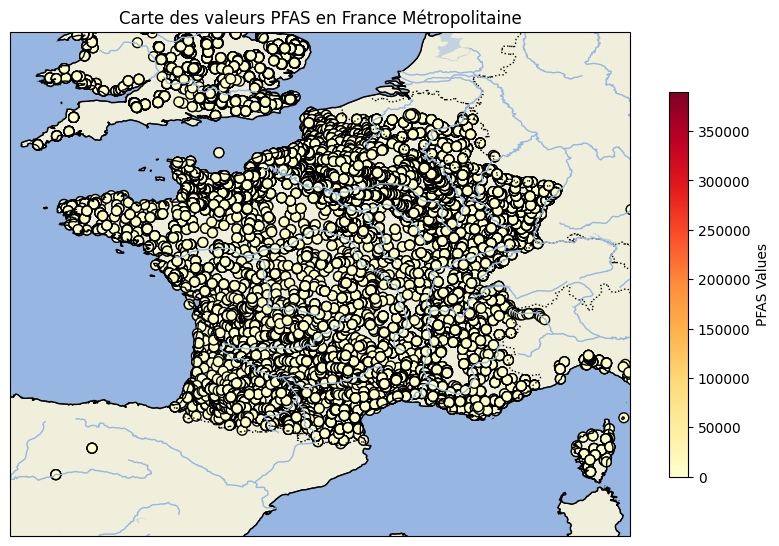

In [8]:
# Créer une figure et une projection Cartopy
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())  # Utilise PlateCarree pour une projection simple

# Ajouter des éléments de base à la carte
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

# Créer une échelle de couleurs pour les valeurs PFAS
# Utilisation de `ax.scatter` avec `transform=ccrs.PlateCarree()` pour bien placer les points
sc = ax.scatter(data_2024['lon'], data_2024['lat'], c=data_2024['pfas_sum'], cmap='YlOrRd', edgecolor='k', s=50, transform=ccrs.PlateCarree())

# Ajouter une barre de couleur
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', shrink=0.5)
cbar.set_label('PFAS Values')

# Définir les limites de la carte sur la France métropolitaine
ax.set_extent([-6, 10, 40, 53], crs=ccrs.PlateCarree())

# Ajouter un titre et afficher la carte
plt.title('Carte des valeurs PFAS en France Métropolitaine')
plt.show()

In [9]:
import numpy as np
from gstlearn import OrdinaryKriging

coordinates = data[['lon', 'lat']].values
values = data['pfas_sum'].values

# Définir les limites de la grille pour le krigeage
grid_lon = np.linspace(data['lon'].min(), data['lon'].max(), 100)
grid_lat = np.linspace(data['lat'].min(), data['lat'].max(), 100)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)
grid_coords = np.column_stack([grid_lon.ravel(), grid_lat.ravel()])

# Créer un modèle de krigeage ordinaire
ok = OrdinaryKriging(coordinates[:, 0], coordinates[:, 1], values, variogram_model='linear')

# Exécuter le krigeage sur la grille
z, ss = ok.execute('grid', grid_lon, grid_lat)

# Visualiser les résultats
plt.figure(figsize=(10, 10))
plt.contourf(grid_lon, grid_lat, z, cmap='YlOrRd')
plt.colorbar(label='PFAS Sum')
plt.scatter(data['lon'], data['lat'], c='black', s=15, label='Sample Points')
plt.title('Kriging of PFAS Sum in France Métropolitaine')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\Nico\anaconda3\envs\foad\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\Nico\anaconda3\envs\foad\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\Nico\anaconda3\envs\foad\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\Ni

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.1 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



ImportError: numpy.core.multiarray failed to import